# Experiment with $\lambda$ and $\tau$ parameters used in knowledge distillation

This is a notebook to run tests to check the effects of certain parameters on the performance of an image classifier model with ViT encoder. 

This notebook is a wrapper of the notebook provided [here](https://keras.io/examples/vision/deit/) that does a grid-walk on certain parameters that are intrinsic to the concept of distillation and creates visualization of the model performance.

## Install and Import

In [1]:
#for additonal capabilities
!pip install tensorflow-addons

In [2]:
#import libraries
from typing import List

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tfds.disable_progress_bar()
tf.keras.utils.set_random_seed(42)

## Hyperparameters for configuration and training

Now, we set some hyper-parameters to configure the model and training data. The description of these variables are given below.


1.   MODEL_TYPE - Name of the model we create
2.   RESOLUTION $(R)$ - The dimension of the input image patch (before getting patches)
3. PATCH_SIZE $(P)$ - The dimension of the patches created from the input image.
4. NUM_PATCHES $(N)$ - Number of patches created. This is given by, $$ N = \left(\frac{P}{R}\right)^2$$
5. LAYER_NORM_EPS - A small value added to the variance to avoid division by 0.
6. PROJECTION_DIM - The projected vector dimension by each transformer block as well as the last layer of the MLP.
7. NUM_HEADS - Number of self-attention heads.
8. NUM_LAYERS - Number of transformer blocks
9. MLP_UNITS - The number of units in the MLP. A list of number of units with the order starting from input to output dimension.
10. DROPOUT_RATE - The probability of dropping out units in each layer of the MLP.
11. DROP_PATH_RATE - The probability of dropping a path in the network. (*More info later*)
12. NUM_EPOCHS - Training epochs
13. BASE_LR - Initial learning rate
14. WEIGHT_DECAY - Rate of decrease of learning rate per epoch.
15. AUTO - Option to parallelize the dataset loading and pre-processing of the input step.





In [15]:
# Model
MODEL_TYPE = "deit_distilled_tiny_patch16_224"
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 4
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 30
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 50
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5

## Pre-process and Load Dataset

We define some augmentation types on the input data. We have used resizing, random cropping and random left or right flip as the augmentation types. 

We have used the **tf_flowers** dataset. For links to detailed description check [here](https://www.tensorflow.org/datasets/catalog/tf_flowers). In short, there are 5 classes of flowers namely *daisy, dandelion, roses, sunflowers, tulips* and a total 3670 images in the  dataset. 

We have train-validation split of 90-10, in order.

In [4]:
def preprocess_dataset(is_training=True):
    def fn(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            image = tf.image.resize(image, (RESOLUTION + 20, RESOLUTION + 20))
            image = tf.image.random_crop(image, (RESOLUTION, RESOLUTION, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
        label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label

    return fn


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=AUTO)
    return dataset.batch(BATCH_SIZE).prefetch(AUTO)


train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 3303
Number of validation examples: 367


In [5]:
for instance in val_dataset:
  print(instance[-1].numpy().shape)

(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(17, 5)


## Define Vanilla ViT Classifier

We now define the "vanilla" ViT model with the transformer blocks and the MLP. 

We have defined a **StochasticDepth** class that implements the drop-path algorithm described [here](https://arxiv.org/abs/1603.09382). Like drop-out that prevents co-adaptation of activations that may lead to overfitting and hence provides a regularization effect, drop-path prevents co-adaptation of parallel paths. This is added in the transformer blocks.

In [6]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [7]:
#a single transformer block

def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and
    # add Dense => Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer(drop_prob: float, name: str) -> keras.Model:
    """Transformer block with pre-norm."""
    num_patches = NUM_PATCHES + 2 if "distilled" in MODEL_TYPE else NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        StochasticDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    # MLP layer 1.
    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = StochasticDepth(drop_prob)(x4) if drop_prob else x4

    # Skip connection 2.
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

In [8]:
class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        # Transformer blocks.
        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output

## Define DeIT Classifier - Extension of ViT with training by distillation

Now we extend the above vanilla "ViT" to DeIT or Data-efficient Image Transformer described [here](https://arxiv.org/abs/2012.12877).

There are 2 tokens or trainable vectors that are used here that interact with each other using the self-attention layer in the transformer. These are:


1.   Class Token - This supervises the model to predict the correct output (ground truth) and is the only vector that is used to predict the output of the model.
2.   Distillation Token - This supervises the model to make predictions that reduces the its difference to that of a teacher model (T). This token interacts with other tokens through the self-attention layer and shares information during training.

The **ViTDistilled** class defines the *student* model.

<mark>**The teacher model is loaded here as well.**</mark> As mentioned in the reference notebook we load a classifier from the BiT family of ResNets that has been fine-tuned on the tf_flower dataset. The teacher model is significantly more complex (40x the parameters in distilled ViT) than the student model.   


In [9]:
!wget -q https://github.com/sayakpaul/deit-tf/releases/download/v0.1.0/bit_teacher_flowers.zip
!unzip -q bit_teacher_flowers.zip

In [10]:
bit_teacher_flowers = keras.models.load_model("bit_teacher_flowers")

In [11]:
class ViTDistilled(ViTClassifier):
    def __init__(self, lamda, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.lamda = lamda
        self.regular_training = regular_training

        # CLS and distillation tokens, positional embedding.
        init_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.dist_token = tf.Variable(init_value, name="dist_token")
        self.positional_embedding = tf.Variable(
            tf.zeros(
                (
                    1,
                    NUM_PATCHES + self.num_tokens,
                    PROJECTION_DIM,
                )
            ),
            name="pos_embedding",
        )

        # Head layers.
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )
        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append the tokens.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1
        )

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Classification heads.
        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            # During standard train / finetune, inference average the classifier
            # logits.
            return (1-self.lamda)*x + self.lamda*x_dist

        elif training:
            # Only return separate classification logits when training in distilled
            # mode.
            return x, x_dist

## Define the DeIT trainer

Now we define the DeIT trainer class. In the original DeIT paper the loss function used is as follows.

$$ \mathbb{L} = \frac{1}{2}\left(\mathbb{L}_{CE}(\psi (Z_s), y) + \mathbb{L}_{CE}(\psi (Z_s), y_t)\right)$$

where $\psi(.)$ is the softmax function. $Z_s$ is the logits from the student model. $y$ and $y_t$ are the ground truth and teacher predictions, respectively. $\mathbb{L}$ is the loss function.

Instead of the equal weightage to both loss functions we introduce a parameter $λ$ as follows.

$$ \mathbb{L} = (1-λ)\mathbb{L}_{CE}(\psi (Z_s), y) + λ\mathbb{L}_{CE}(\psi (Z_s), y_t)$$

where $\mathbb{L}_{CE}$ is cross-entropy loss.

The *temperature* parameter used in the original distillation paper proposed [here](https://arxiv.org/abs/1503.02531) has not been used used in the original DeIT implementation. However, in this experiment we play with this parameter as well. The modified loss function then will be as follows.

$$ \mathbb{L} = (1-λ)\mathbb{L}_{CE}(\psi (Z_s), y) + λτ^2 \mathbb{L}_{KL}(\psi (Z_s/τ), \psi (Z_t/τ))$$

where τ is the temperature parameter and $\mathbb{L}_{KL}$ is the KL divergence and $Z_t$ is the logits from the teacher model.

**NOTE**: Both teacher and student models give logits (arguments to softmax) from the output layer.

In [12]:
class DeiT(keras.Model):
    # Reference:
    # https://keras.io/examples/vision/knowledge_distillation/
    def __init__(self, student, teacher, lamda, temp = None, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher
        self.lamda = lamda
        if temp is not None:
          assert temp>0, "temperature has to be positive"
        self.temp = temp

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        # Unpack data.
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)             #teacher logits
        if self.temp is not None:
            teacher_predictions = teacher_predictions/self.temp           #soft probability distribution

        teacher_predictions = tf.nn.softmax(teacher_predictions, -1)      #compute probability distribution

        if self.temp is None:    
            teacher_predictions = tf.argmax(teacher_predictions, -1)      #compute labels from probability dist


        with tf.GradientTape() as tape:
            # Forward pass of student.
            cls_predictions, dist_predictions = self.student(x / 255.0, training=True)  #student logits
            
            #if temperature is set then we compute the probability distribution of dist_classification tensor
            #keras KL-divergence loss computes loss on probability distribution
            #and does not compute loss from logits
            if self.temp is not None:
                dist_predictions = dist_predictions/self.temp
                dist_predictions = tf.nn.softmax(dist_predictions, axis=-1)

            # Compute losses.
            student_loss = self.student_loss_fn(y, cls_predictions)               #from logits
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, dist_predictions
            )                                                                   
            if self.temp is not None:
                loss = (1-self.lamda)*student_loss + self.lamda*(self.temp**2)*distillation_loss
            else:                                                                    
                loss = (1-self.lamda)*student_loss + self.lamda*distillation_loss

        # Compute gradients.
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        student_predictions = (1-self.lamda)*cls_predictions + self.lamda*dist_predictions
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions.
        y_prediction = self.student(x / 255.0, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs / 255.0, training=False)

## Testing with λ Parameter

We have used **categorical cross-entropy** for student loss and **sparse categorical cross entropy** as the teacher loss. The optimizer used is AdamW provided by the keras addon library.

We visualize the validation and training loss of the last epoch of student model for each value of the lambda parameter.

In [13]:
cand_lamda = [l/10 for l in range(1, 11, 2)]
val_accuracy_history = []
train_accuracy_history = []
print(cand_lamda)

[0.1, 0.3, 0.5, 0.7, 0.9]


In [18]:
for lamda in cand_lamda:
  deit_tiny = ViTDistilled(lamda=lamda)
  deit_distiller = DeiT(student=deit_tiny, teacher=bit_teacher_flowers, lamda = lamda)

  lr_scaled = (BASE_LR / 512) * BATCH_SIZE
  deit_distiller.compile(
      optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
      metrics=["accuracy"],
      student_loss_fn=keras.losses.CategoricalCrossentropy(
          from_logits=True, label_smoothing=0.1
      ),
      distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  )
  training_history = deit_distiller.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)
  val_accuracy_history.append(training_history.history['val_accuracy'][-1])
  train_accuracy_history.append(training_history.history['accuracy'][-1])

Epoch 1/30
67/67 [==============================] - 70s 919ms/step - accuracy: 0.2949 - student_loss: 1.6471 - distillation_loss: 1.6170 - val_accuracy: 0.3733 - val_student_loss: 1.4570 - val_distillation_loss: 0.0000e+00
Epoch 2/30
67/67 [==============================] - 60s 901ms/step - accuracy: 0.4178 - student_loss: 1.3740 - distillation_loss: 1.3629 - val_accuracy: 0.3896 - val_student_loss: 1.3989 - val_distillation_loss: 0.0000e+00
Epoch 3/30
67/67 [==============================] - 60s 895ms/step - accuracy: 0.4935 - student_loss: 1.2967 - distillation_loss: 1.2246 - val_accuracy: 0.4741 - val_student_loss: 1.3193 - val_distillation_loss: 0.0000e+00
Epoch 4/30
67/67 [==============================] - 60s 901ms/step - accuracy: 0.5213 - student_loss: 1.2607 - distillation_loss: 1.1772 - val_accuracy: 0.5095 - val_student_loss: 1.2133 - val_distillation_loss: 0.0000e+00
Epoch 5/30
67/67 [==============================] - 60s 902ms/step - accuracy: 0.5643 - student_loss: 1.1847

In [19]:
print(val_accuracy_history)
print(train_accuracy_history)

[0.7057220935821533, 0.7057220935821533, 0.7247956395149231, 0.6839237213134766, 0.752043604850769]
[0.7335755228996277, 0.7320617437362671, 0.7441719770431519, 0.7387223839759827, 0.7338783144950867]


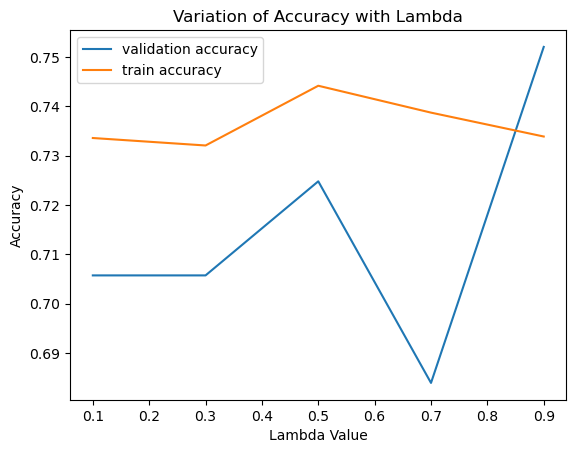

In [20]:
plt.plot(cand_lamda, val_accuracy_history, label = 'validation accuracy')
plt.plot(cand_lamda, train_accuracy_history, label = 'train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Lambda Value')
plt.title('Variation of Accuracy with Lambda')
plt.legend()
plt.savefig('lambda_experiment.pdf')

## Testing with τ parameter

We keep everything same as for the experiment with λ parameter except the loss function used on the distillation token and the teacher predictions. In this experiment we have used the Kullback-Leibler divergence loss and made the necessary changes in the training step.

**NOTE** : We keep λ parameter fixed to 0.9 as this gave best results in the above experiment.

In [21]:
cand_temp = [1, 5, 10, 15, 20]
temp_val_accuracy_history = []
temp_train_accuracy_history = []
print(cand_temp)

[1, 5, 10, 15, 20]


In [22]:
for temp in cand_temp:
  deit_tiny = ViTDistilled(lamda=0.9)
  deit_distiller = DeiT(student=deit_tiny, teacher=bit_teacher_flowers, lamda = 0.9, temp=temp)

  lr_scaled = (BASE_LR / 512) * BATCH_SIZE
  deit_distiller.compile(
      optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
      metrics=["accuracy"],
      student_loss_fn=keras.losses.CategoricalCrossentropy(
          from_logits=True, label_smoothing=0.1
      ),
      distillation_loss_fn=keras.losses.KLDivergence()
  )
  training_history = deit_distiller.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)
  temp_val_accuracy_history.append(training_history.history['val_accuracy'][-1])
  temp_train_accuracy_history.append(training_history.history['accuracy'][-1])

Epoch 1/30
67/67 [==============================] - 68s 907ms/step - accuracy: 0.2991 - student_loss: 1.6526 - distillation_loss: 1.5436 - val_accuracy: 0.3106 - val_student_loss: 1.5559 - val_distillation_loss: 0.0000e+00
Epoch 2/30
67/67 [==============================] - 60s 901ms/step - accuracy: 0.4187 - student_loss: 1.4237 - distillation_loss: 1.2706 - val_accuracy: 0.4142 - val_student_loss: 1.3659 - val_distillation_loss: 0.0000e+00
Epoch 3/30
67/67 [==============================] - 60s 902ms/step - accuracy: 0.4941 - student_loss: 1.3152 - distillation_loss: 1.1551 - val_accuracy: 0.4959 - val_student_loss: 1.3023 - val_distillation_loss: 0.0000e+00
Epoch 4/30
67/67 [==============================] - 60s 900ms/step - accuracy: 0.5389 - student_loss: 1.2639 - distillation_loss: 1.0741 - val_accuracy: 0.5531 - val_student_loss: 1.2515 - val_distillation_loss: 0.0000e+00
Epoch 5/30
67/67 [==============================] - 60s 897ms/step - accuracy: 0.6007 - student_loss: 1.1926

In [23]:
print(temp_val_accuracy_history)
print(temp_train_accuracy_history)

[0.6621253490447998, 0.7356948256492615, 0.7302452325820923, 0.692098081111908, 0.7057220935821533]
[0.7384195923805237, 0.7069330811500549, 0.7465940117835999, 0.7232818603515625, 0.7254011631011963]


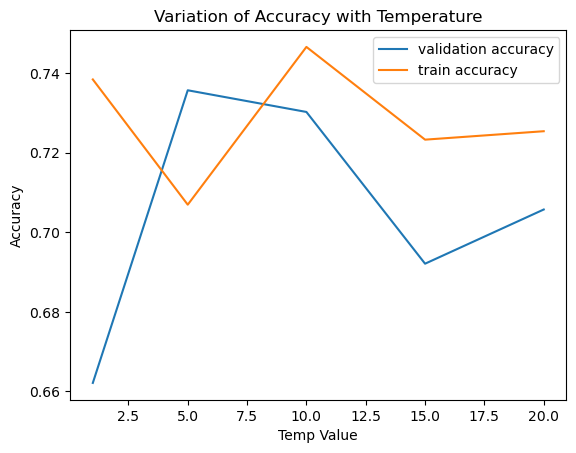

In [24]:
plt.plot(cand_temp, temp_val_accuracy_history, label = 'validation accuracy')
plt.plot(cand_temp, temp_train_accuracy_history, label = 'train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Temp Value')
plt.title('Variation of Accuracy with Temperature')
plt.legend()
plt.savefig('temp_experiment.pdf')